In [ ]:
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import njit
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import kurtosis
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from utils import build_dict, isolate_option_types

In [2]:
STOCK_PRICE_RELATIVE_PATH = "/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/5min_hist_SPY_2023.csv"
OPTIONS_CHAIN_RELATIVE_PATH = "/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/spy_options_15mins/spy_15x_2023q1/spy_15x_202301.txt"

In [3]:
stock_price_data = pd.read_csv(STOCK_PRICE_RELATIVE_PATH)

In [4]:
with open(OPTIONS_CHAIN_RELATIVE_PATH, "r") as f:
    options_chain_data = f.readlines()

raw_keys = options_chain_data[0]
options_hist_data = [
    item
    for raw_values in options_chain_data[1:]
    for item in isolate_option_types(build_dict(raw_keys, raw_values))
]
options_chain_data_hist = pd.DataFrame(options_hist_data)

In [5]:
options_chain_data[:3]

['[QUOTE_UNIXTIME], [QUOTE_READTIME], [QUOTE_DATE], [QUOTE_TIME_HOURS], [UNDERLYING_LAST], [EXPIRE_DATE], [EXPIRE_UNIX], [DTE], [C_DELTA], [C_GAMMA], [C_VEGA], [C_THETA], [C_RHO], [C_IV], [C_VOLUME], [C_LAST], [C_SIZE], [C_BID], [C_ASK], [STRIKE], [P_BID], [P_ASK], [P_SIZE], [P_LAST], [P_DELTA], [P_GAMMA], [P_VEGA], [P_THETA], [P_RHO], [P_IV], [P_VOLUME], [STRIKE_DISTANCE], [STRIKE_DISTANCE_PCT]\n',
 '1672756210, 2023-01-03 09:30, 2023-01-03, 9.500000, 384.420000, 2023-01-03, 1672779600, 0.270000, 1.000000, 0.000000, 0.000000, 0.000000, 0.000000, , 0.000000, 73.660000, 1 x 1, 73.730000, 74.930000, 310.000000, 0.000000, 0.010000, 0 x 6217, 0.010000, -0.001030, 0.000170, 0.000190, -0.005120, -0.000470, 1.005550, 0.000000, 74.400000, 0.194000\n',
 '1672756210, 2023-01-03 09:30, 2023-01-03, 9.500000, 384.420000, 2023-01-03, 1672779600, 0.270000, 0.922300, 0.006510, 0.021150, -0.469680, 0.000790, 3.985680, 0.000000, 62.710000, 1 x 1, 63.720000, 66.040000, 320.000000, 0.000000, 0.010000, 0 x

In [140]:
# options data manip
options_chain_data_hist_reduced = options_chain_data_hist.rename(columns={"quote_readtime": "datetime"})
call_chain_data_hist_reduced = options_chain_data_hist_reduced.loc[
    options_chain_data_hist_reduced["type"] == "call",
    ["datetime", "strike", "iv", "expire_date", "last", "bid", "ask", "volume", "size", "delta", "gamma", "vega", "theta", "rho"]
]
put_chain_data_hist_reduced = options_chain_data_hist_reduced.loc[
    options_chain_data_hist_reduced["type"] == "put",
    ["datetime", "strike", "iv", "expire_date", "last", "bid", "ask", "volume", "size", "delta", "gamma", "vega", "theta", "rho"]
]

# stocks data manip
stock_price_data_15min = stock_price_data.loc[stock_price_data["date"].apply(
    lambda x:(":30" in x[:-3]) or (":15" in x[:-3]) or (":00" in x[:-3]) or (":45" in x[:-3])
), ["date", "open", "volume"]]
stock_price_data_15min = stock_price_data_15min.rename(columns={"date": "datetime", "volume": "underlying_volume"})
stock_price_data_15min["datetime"] = stock_price_data_15min["datetime"].apply(lambda x: x[:-3])

# reset indexes
call_chain_data_hist_reduced = call_chain_data_hist_reduced.set_index("datetime")
put_chain_data_hist_reduced = put_chain_data_hist_reduced.set_index("datetime")
stock_price_data_15min = stock_price_data_15min.set_index("datetime")

concat_call_options_chain_prices = call_chain_data_hist_reduced.join(stock_price_data_15min, how="left")
concat_call_options_chain_prices = concat_call_options_chain_prices[concat_call_options_chain_prices.index.map(lambda x: " 16:00" not in x)]

In [141]:
# Ensure datetime index is datetime type and sorted
df = concat_call_options_chain_prices.copy()
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Function to process a single (strike, expiry) group
def tag_returns_process_group(strike, expire_date, group):
    group = group.sort_index()
    times = group.index
    asks = group['ask'].values
    bids = group['bid'].values
    labels = np.zeros(len(group), dtype=np.int8)
    percent_increase = np.zeros(len(group), dtype=np.float16)
    hours_to_max = np.zeros(len(group), dtype=np.float16)

    for i in range(len(group)):
        ask_t = asks[i]
        if ask_t == 0:
            continue

        time_t = times[i]
        window_end = min(time_t + pd.Timedelta(weeks=1), pd.to_datetime(expire_date))
        mask = (times > time_t) & (times <= window_end)

        future_bids = bids[mask]
        future_times = times[mask]
        returns = (future_bids - ask_t) / ask_t if len(future_bids) > 0 else np.array([])

        if len(returns) > 0:
            max_idx = np.argmax(returns)
            max_return = returns[max_idx]
            max_time = future_times[max_idx]

            if max_return >= 1: # greater or equals to 100%
                labels[i] = 1
                percent_increase[i] = (np.max(bids[mask]) - ask_t) / ask_t
                hours_to_max[i] = (max_time - time_t).total_seconds() / 3600.0  # in hours

    group_result = group.copy()
    group_result['label'] = labels
    group_result['percent_increase'] = percent_increase
    group_result['hours_to_max'] = hours_to_max

    return group_result

# Group the DataFrame
grouped = df.groupby(['strike', 'expire_date'])

# Process in parallel
results = Parallel(n_jobs=-1, backend='loky')(
    delayed(tag_returns_process_group)(strike, expire_date, group)
    for (strike, expire_date), group in tqdm(grouped, desc="Processing groups")
)

# Combine results
df_labeled = pd.concat(results).sort_index()

Processing groups: 100%|██████████| 6641/6641 [00:41<00:00, 158.50it/s]


In [142]:
df_labeled.head()

/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,strike,iv,expire_date,last,bid,ask,volume,size,delta,gamma,vega,theta,rho,open,underlying_volume,label,percent_increase,hours_to_max
datetime,,,,,,,,,,,,,,,,,,
2023-01-03 09:30:00,120.0,0.47386,2024-12-20,261.90,261.80,271.80,0.0,20 x 10,0.96802,0.00026,0.21859,-0.00764,1.48139,384.37,1973684.0,0,0.0,0.0
2023-01-03 09:30:00,350.0,0.26169,2023-09-29,73.71,57.10,59.04,0.0,100 x 100,0.73307,0.00373,1.06224,-0.07085,1.65471,384.37,1973684.0,0,0.0,0.0
2023-01-03 09:30:00,350.0,0.26361,2023-09-15,56.40,56.55,58.27,0.0,10 x 10,0.73505,0.00373,1.03201,-0.07365,1.57997,384.37,1973684.0,0,0.0,0.0
2023-01-03 09:30:00,350.0,0.26292,2023-06-30,50.48,50.27,51.91,0.0,100 x 19,0.75056,0.00444,0.83973,-0.08187,1.16307,384.37,1973684.0,0,0.0,0.0
2023-01-03 09:30:00,350.0,0.26490,2023-06-16,47.64,49.68,51.12,0.0,120 x 210,0.75534,0.00454,0.79960,-0.08671,1.08544,384.37,1973684.0,0,0.0,0.0


<Axes: xlabel='datetime'>

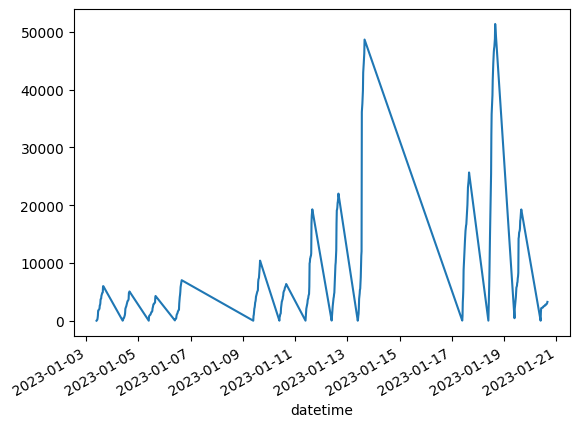

In [38]:
df_labeled.loc[(df_labeled["strike"] == 400) & (df_labeled["expire_date"] == "2023-01-20"), "volume"].head(500).plot()

In [150]:
# original volume data contains cumulative volume per day
# let's compute delta volume

df_labeled['date'] = df_labeled.index.date
df_labeled['delta_volume'] = (
    df_labeled.groupby(['date', 'strike', 'expire_date'])['volume']
      .diff()
      .fillna(0)  # The first row of each group gets NaN from diff; fill it with 0
)
df_labeled = df_labeled.drop(columns='date')

<Axes: xlabel='datetime'>

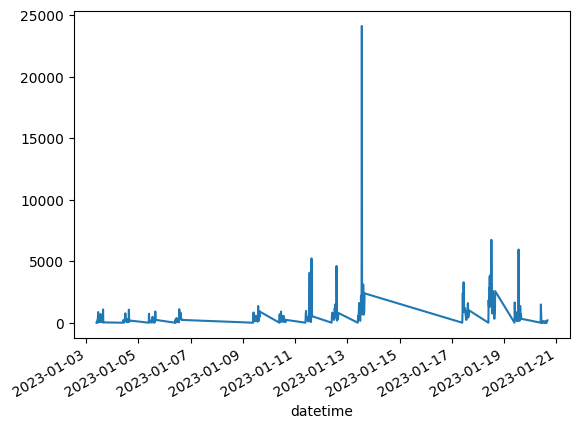

In [10]:
df_labeled.loc[(df_labeled["strike"] == 400) & (df_labeled["expire_date"] == "2023-01-20"), "delta_volume"].head(500).plot()

$$ \frac{\sum_{j=1}^{J}VOL_j * \frac{|(P_t^j - P_{t-1}^j) - \Delta_{t-1}^{j}(S_t - S_{t-1})|}{DVOL_t^j}}{\sum_{j=1}^{J}VOL_j} $$

$$ IV_{i,t} = \int_{S_{i,t}}^{\infty} \frac{2\left(1 - \log({\frac{K_i}{S_{i,t}}})\right)}{K_i^2} C(t, \tau; K_i) dK_i + 
\int_{0}^{S_{i,t}} \frac{2\left(1 + \log({\frac{S_{i,t}}{K_i}})\right)}{K_i^2} P(t, \tau; K_i) dK_i $$

$$ IV_{i,t}^+ = \int_{S_{i,t}}^{\infty} \frac{2\left(1 - \log({\frac{K_i}{S_{i,t}}})\right)}{K_i^2} C(t, \tau; K_i) dK_i $$

$$ IV_{i,t}^- = \int_{0}^{S_{i,t}} \frac{2\left(1 + \log({\frac{S_{i,t}}{K_i}})\right)}{K_i^2} P(t, \tau; K_i) dK_i $$

$$ ivd = \sum_{j=1}^{J} \frac{\Delta{IV_j^2}}{sum_{j}\Delta{IV_j^2}} \times \tau_j $$

$$ m \_ degree = \frac{log(K/S_t)}{\sqrt{\tau} \times IV_{t, \tau}^{atm}} $$

$$ R_t = \sum_{n=1}^{20} \left( V_{t-n} \prod_{\tau=1}^{n-1} [1-V_{t-n+\tau}] \right) O_{t-n} $$

$$ \text{pfht} = 2 \times \sigma \times \Phi^{-1} \left( \frac{1 + pzeros}{2} \right) $$

$$ R_{i, d} = \beta_{0} + \beta_{i}^{MKT} MKT_{d} + \beta_{i}^{BEAR}R_{AD Bear, d} + \epsilon_{i, d} $$

According to study [Option return predictability with machine learning and big data](https://academic.oup.com/rfs/article-abstract/36/9/3548/7056660), page 41, we will take into consideration (for now) the first 4 feature groups per importance. These are:

- Ill=Illiquidity ;
- C=Contract ;
- Risk=Risk ;
- Past=Past Prices ;

The list of features is described below:

- ailliq (Absolute illiquidity) -> Ill
- amihud (Amihud illiquidity per bucket) -> Ill
- baspread (Bid-ask spread) -> Ill
- bucket_dvol (Option bucket dollar volume) -> Ill
- bucket_vol (Option bucket volume) -> Ill
- bucket_vol_share (Relative option bucket volume) -> Ill
- C (Call indicator) -> C
- atm_iv (At-the-money implied volatility (maturity-specific)) -> Risk
- bear beta (Bear beta) -> Risk
- beta (Beta) -> Risk
- betasq (Beta squared) -> Risk
- cfp (Cash-flow-to-price ratio) -> Risk
- cfp_ia (Industry-adjusted cash-flow-to-price ratio) -> Risk
- chmom (Change in 6-month momentum) -> Past

- doi (Dollar open interest) -> Ill
- dvol (Dollar trading volume) -> Ill
- gammaps (Pastor and Stambaugh liquidity measure ) -> Ill

- convind (Convertible debt indicator) -> Risk
- defrisk (Default risk) -> Risk
- delta (Delta) -> Risk
- embedlev (Embedded Leverage) -> Risk
- gamma Gamma -> Risk
- hkurt Historic kurtosis -> Risk

- hskew (Historic skewness) -> Risk
- hvol (Historic Volatility) -> Risk
- idiovol (Idiosyncratic return volatility) -> Risk
- ill (Amihud Illiquidity) -> Ill
- illiq (Illiquidity) -> Ill

- indmom (Industry momentum) -> Past
- iv (Implied volatility) -> Contract
- iv rank (Implied volatility rank vs. last year) -> Past

- ivarud30 (Option implied variance asymmetry) -> Risk
- ivd (Implied volatility duration) -> Risk
- ivrv (Implied volatility minus realized volatility) -> Risk
- ivrv_ratio (Implied volatility minus realized volatility ratio) -> Risk
- ivslope (Implied volatility) -> Risk
- ivvol (Volatility of atm volatility) -> Risk
- m_degree (Standardized strike) -> Risk
- mid (Option mid price) -> C

- mom12m (12-month momentum) -> Past
- mom1m (1-month momentum) -> Past
- mom36m (36-month momentum) -> Past
- mom6m (6-month momentum) -> Past
- moneyness (Moneyness) -> C
- nopt (Number of options trading) -> Ill
- ocgo (Disposition Effect) -> Past
- oi (Open interest) -> Ill
- optspread (Option bid-ask spread) -> Ill
- P (Put-flag) -> C
- pba (Proportional bid-ask spread) -> Ill

- pfht (Modified illiquidity measure based on zero returns) -> Ill
- pifht (An extended FHT measured based on zero returns) -> Ill
- pilliq (Percentage illiquidity) -> Ill
- piroll (Extended Roll’s measure) -> Ill
- pricedelay (Price delay) -> Ill
- pzeros (Illiquidity measure based on zero returns) -> Ill
- retvol (Return volatility) -> Risk
- rnk182 (182-day risk-neutral kurtosis) -> Risk
- rnk273 (273-day risk-neutral kurtosis) -> Risk
- rnk30 (30-day risk-neutral kurtosis) -> Risk
- rnk365 (365-day risk-neutral kurtosis) -> Risk
- rnk91 (91-day risk-neutral kurtosis) -> Risk
- rns182 (182-day risk-neutral skewness) -> Risk
- rns273 (273-day risk-neutral skewness) -> Risk
- rns30 (30-day risk-neutral skewness) -> Risk
- rns365 (365-day risk-neutral skewness) -> Risk

- rns91 (91-day risk-neutral skewness) -> Risk
- roll (Roll’s measure of illiquidity) -> Ill
- rv (Realized variance) -> Risk
- season1 (Seasonal return - 1 year historical) -> Past
- season2 (Seasonal return - 2 year historical) -> Past
- season3 (Seasonal return - 3 year historical) -> Past
- season4 (Seasonal return - 4 year historical) -> Past
- std_dolvol (Volatility of liquidity (dollar trading volume)) -> Ill
- std_turn (Volatility of liquidity (share turnover)) -> Ill
- stdamihud (Standard deviation of Amihud’s illiquidity measure) -> Ill
- stdcf (Cash flow volatility) -> Risk

- tb (Tax income to book income) -> Past
- theta (Theta) -> Risk
- tlm30 (Tail loss measure) -> Risk
- toi (Total option open interest) -> Ill
- ttm (Time-to-maturity) -> Contract
- turn (Share turnover) -> Risk
- turnover (Option turnover) -> Ill
- vega (Vega) -> Risk
- vol (Trading volume in options) -> Ill
- volga (Volga) -> Risk
- volunc (Volatility uncertainty) -> Risk
- zerotrade (Zero trading days) -> Ill

In [151]:
# dollar volume
df_labeled["dvol"] = df_labeled["delta_volume"] * ((df_labeled["ask"] + df_labeled["bid"]) / 2)

# aboslute illiquidity
ask_price_diff = df_labeled.groupby(["strike", "expire_date"])["ask"].diff().fillna(0)
stock_price_diff = df_labeled.groupby(["strike", "expire_date"])["open"].diff().fillna(0)
df_labeled["ailliq"] = abs(ask_price_diff - df_labeled["delta"] * stock_price_diff) / df_labeled["dvol"]

# amihud illiquidity
stock_return = stock_price_diff / df_labeled["open"].shift(1).fillna(0)
df_labeled["amihudilliq"] = abs(stock_return) / df_labeled["dvol"]

# bid ask spread
df_labeled["baspread"] = df_labeled["ask"] - df_labeled["bid"]

# relative bid ask spread
midpoint = (df_labeled["bid"] + df_labeled["ask"]) / 2
df_labeled["rel_baspread"] = df_labeled["baspread"] / midpoint

# EXTRA FOR LATER USE
# stock and option return (1 timestep)
df_labeled['open_return'] = df_labeled['open'].pct_change().fillna(0)
prev_ask = df_labeled['ask'].shift(1)
numerator = df_labeled['bid'] - prev_ask
denominator = prev_ask

# Avoid division by zero explicitly
df_labeled['option_return'] = np.where(
    denominator != 0,
    numerator / denominator,
    0  # If denominator is zero, return 0
)

In [ ]:
# compute ailliq

def compute_dollar_vol(option, vol_col="delta_volume"):
    volume = option[vol_col]
    ask = option["ask"]
    bid = option["bid"]
    return volume * ((ask + bid) / 2)

def compute_ailliq(option):
    """
    'last' refers to last traded price of option
    according to data source documentation. It
    is used as the transaction price in this
    calculation.
    """
    pt = option["ask"]
    pt_1 = option["ask_t-1"]
    delta =  option["delta"]
    st = option["open_t0"]
    st_1 = option["open_t-1"]
    dollar_vol = compute_dollar_vol(option)
    return abs((pt - pt_1) - delta * (st - st_1)) / dollar_vol

In [ ]:
# compute amihud illiquidity

def amihudilliq(option):
    """
    amihud is thought for daily options
    this is a custom adaptation for 15 mins
    frequecy
    """
    pt = option["open_t0"]
    pt_1 = option["open_t-1"]
    p_return = (pt - pt_1) / pt_1
    dollar_vol = compute_dollar_vol(option)
    return abs(p_return) / dollar_vol

In [ ]:
# compute bid-ask spread
# and also relative bid-ask spread
# since it is not clear which definition
# is used in the paper

def compute_midpoint(option):
    bid = option["bid"]
    ask = option["ask"]
    return (bid + ask) / 2

def baspread(option):
    bid = option["bid"]
    ask = option["ask"]
    return ask - bid

def rel_baspread(option):
    spread = baspread(option)
    midpoint = compute_midpoint(option)
    return spread / midpoint

In [ ]:
# bucket_vol and bucket_dvol are
# already computed for us on a contract
# level. to compute bucket_vol_share we
# need volume of all options from same
# underlying. Leave it in stand by for now

In [ ]:
# atm_iv is basically the iv value for a strike
# equals to the stock price and specific time to 
# maturity (expiration date) which is not useful
# for a specific option contract unless this option
# contract is super close unless the option is very
# close to atm. Perhaps a relative measure might
# be more representative

In [ ]:
@njit
def compute_bear_beta_numba(contract_indices, mid_rets, under_rets, window, min_points):
    n = len(contract_indices)
    bear_beta = np.full(n, np.nan)

    current = contract_indices[0]
    start = 0

    for i in range(1, n):
        if contract_indices[i] != current or i == n - 1:
            end = i if i != n - 1 else n
            for t in range(start + window, end):
                x_win = under_rets[start + t - window:t]
                y_win = mid_rets[start + t - window:t]

                valid = (x_win < 0) & (~np.isnan(y_win))
                if np.sum(valid) >= min_points:
                    x_valid = x_win[valid]
                    y_valid = y_win[valid]
                    x_c = x_valid - x_valid.mean()
                    y_c = y_valid - y_valid.mean()
                    var = np.dot(x_c, x_c)
                    beta = np.dot(x_c, y_c) / var if var > 0 else np.nan
                    bear_beta[start + t] = beta
            current = contract_indices[i]
            start = i

    return bear_beta

def apply_bear_beta(df, window=16, min_points=3):
    df = df.sort_values(['contract_id', df.index.name]).copy()
    df['mid_price'] = (df['bid'] + df['ask']) / 2
    df['mid_ret'] = df.groupby('contract_id')['mid_price'].pct_change()
    under_ret = df.groupby(df.index)['open'].first().pct_change()
    df['under_ret'] = df.index.map(under_ret)

    contract_codes = pd.factorize(df['contract_id'])[0].astype(np.int32)

    bear_beta = compute_bear_beta_numba(
        contract_codes,
        df['mid_ret'].values.astype(np.float64),
        df['under_ret'].values.astype(np.float64),
        window,
        min_points,
    )

    df['bear_beta'] = bear_beta
    df = df.drop(columns=['mid_price', 'mid_ret', 'under_ret'], axis=1)
    return df


df_labeled['contract_id'] = df_labeled['strike'].astype(str) + '_' + df_labeled['expire_date'].astype(str)
df_labeled = apply_bear_beta(df_labeled, window=16, min_points=3)
df_labeled = df_labeled.drop(columns=["contract_id"], axis=1)

gc.collect()

In [ ]:
# we assume beta is the analogy of bear beta for
# positive returns.

@njit
def compute_beta_numba(contract_indices, mid_rets, under_rets, window, min_points):
    n = len(contract_indices)
    beta = np.full(n, np.nan)

    current = contract_indices[0]
    start = 0

    for i in range(1, n):
        if contract_indices[i] != current or i == n - 1:
            end = i if i != n - 1 else n
            for t in range(start + window, end):
                x_win = under_rets[start + t - window:t]
                y_win = mid_rets[start + t - window:t]

                valid = (x_win > 0) & (~np.isnan(y_win))  # <-- upside moves only
                if np.sum(valid) >= min_points:
                    x_valid = x_win[valid]
                    y_valid = y_win[valid]
                    x_c = x_valid - x_valid.mean()
                    y_c = y_valid - y_valid.mean()
                    var = np.dot(x_c, x_c)
                    beta_val = np.dot(x_c, y_c) / var if var > 0 else np.nan
                    beta[start + t] = beta_val
            current = contract_indices[i]
            start = i

    return beta

def apply_beta(df, window=16, min_points=3):
    df = df.sort_values(['contract_id', df.index.name]).copy()
    df['mid_price'] = (df['bid'] + df['ask']) / 2
    df['mid_ret'] = df.groupby('contract_id')['mid_price'].pct_change()

    under_ret = df.groupby(df.index)['open'].first().pct_change()
    df['under_ret'] = df.index.map(under_ret)

    contract_codes = pd.factorize(df['contract_id'])[0].astype(np.int32)

    beta_vals = compute_beta_numba(
        contract_codes,
        df['mid_ret'].values.astype(np.float64),
        df['under_ret'].values.astype(np.float64),
        window,
        min_points,
    )

    df['beta'] = beta_vals
    df = df.drop(columns=['mid_price', 'mid_ret', 'under_ret'], axis=1)
    return df

df_labeled['contract_id'] = df_labeled['strike'].astype(str) + '_' + df_labeled['expire_date'].astype(str)
df_labeled = apply_beta(df_labeled, window=16, min_points=3)
df_labeled = df_labeled.drop(columns=["contract_id"], axis=1)
gc.collect()

14995

In [ ]:
# we squared beta to be beta * beta
# and we will not consider it for now
# since high absolute correlation
# between these two features

In [ ]:
# instead of the change in 6 months momemtum we will
# do normalized momentum between t and : t-1, t-2, t-3
# t-4, t-5, t-10, t-15 (assuming window of 16) because
# absolute value can change significantly over time

def compute_normalized_momentum(df):
    df = df.copy()
    df = df.sort_index()

    # Lags to compute
    lags = [1, 2, 3, 4, 5, 10, 15]

    # Group by unique contract (strike + expire_date)
    grouped = df.groupby(['strike', 'expire_date'])

    # Compute normalized momentum for each lag
    for lag in lags:
        col_name = f'norm_mom_{lag}'
        df[col_name] = grouped['open'].transform(lambda x: (x - x.shift(lag)) / x.shift(lag))

    return df

df_labeled = compute_normalized_momentum(df_labeled)

In [ ]:
# Dollar open interest is not implemented
# since option open interest is not present
# in the options dataset

In [ ]:
# dollar trading volume is the dvol we
# use for ailliq and amihud illiq

# df_labeled["dvol"] = 0.0
# df_labeled["dvol"].astype(float)
# mask = (df_labeled["delta_volume"] != 0.0)
# df_labeled.loc[mask, "dvol"] = (
#     (df_labeled.loc[mask, "ask"] + df_labeled.loc[mask, "bid"]) / 2 * df_labeled.loc[mask, "delta_volume"]
# ).values

In [ ]:
# pastor stambough liquidity value
# is still poorly understood by me

def compute_ps_liquidity(df: pd.DataFrame, window: int = 16) -> pd.DataFrame:
    df = df.copy()

    # Midquote
    df["midquote"] = (df["bid"] + df["ask"]) / 2

    # Group contracts
    df["contract_id"] = df.groupby(["strike", "expire_date"], sort=False).ngroup()

    # Prepare output array
    psliq = np.full(len(df), np.nan)

    # Work on NumPy arrays for speed
    midquote = df["midquote"].values
    volume = df["volume"].values
    contract_ids = df["contract_id"].values

    # Loop over unique contracts
    for cid in np.unique(contract_ids):
        idx = np.where(contract_ids == cid)[0]

        if len(idx) < window:
            continue

        mid = midquote[idx]
        vol = volume[idx]

        # Compute forward return
        ret = np.full_like(mid, np.nan, dtype=np.float64)
        
        # 'ret[:-1] = (mid[1:] - mid[:-1]) / mid[:-1]' is
        # substituted by the following 3 lines to avoid zero div
        # but it might understate return calculations
        ret[:-1] = 0.0  # initialize safely
        safe = mid[:-1] != 0.0
        ret[:-1][safe] = (mid[1:][safe] - mid[:-1][safe]) / mid[:-1][safe]

        # Compute flow proxy
        flow = np.full_like(mid, np.nan, dtype=np.float64)
        flow[1:] = np.sign(ret[:-1]) * np.sqrt(np.maximum(vol[:-1], 0))

        # Rolling regression
        for i in range(window, len(idx)):
            y = ret[i - window + 1:i + 1]
            x = flow[i - window + 1:i + 1]

            if np.any(np.isnan(y)) or np.any(np.isnan(x)):
                continue

            x_mat = np.column_stack((np.ones_like(x), x))
            beta, *_ = np.linalg.lstsq(x_mat, y, rcond=None)
            psliq[idx[i]] = beta[1]

    df["psliq"] = psliq
    df.drop(columns=["contract_id", "midquote"], inplace=True)
    return df

df_labeled = df_labeled.sort_index()
df_labeled = compute_ps_liquidity(df_labeled)

In [115]:
# need financial statements data to compute
# Convertible debt indicator

In [116]:
# need financial statements data to compute
# default risk

In [ ]:
# embedded leverage
# ask price is used as the options price

df_labeled["embedded_leverage"] = abs(df_labeled["delta"]) * df_labeled["open"] / df_labeled["ask"]

In [93]:
# kurtosis
# unclear definition is given in the paper
# don't know whether it is computed for the
# stock price or the option. I calculate it
# for now with the stock price.
# if division by zero I assign 0

@njit
def rolling_kurtosis_numba(arr, window):
    n = len(arr)
    result = np.empty(n)
    result[:] = np.nan

    for i in range(window - 1, n):
        window_slice = arr[i - window + 1:i + 1]
        mean = np.mean(window_slice)
        m2 = np.mean((window_slice - mean) ** 2)
        m4 = np.mean((window_slice - mean) ** 4)
        if m2 != 0:
            result[i] = m4 / (m2 ** 2)
        else:
            result[i] = 0
    return result

def fast_grouped_kurtosis(df, window=16):
    results = []
    for _, group in df.groupby(['strike', 'expire_date']):
        arr = group['open'].to_numpy()
        kurt_vals = rolling_kurtosis_numba(arr, window)
        group = group.copy()
        group['historic_kurtosis'] = kurt_vals
        results.append(group)
    return pd.concat(results)

df_labeled = fast_grouped_kurtosis(df_labeled.copy())

In [ ]:
@njit
def rolling_skew_numba(arr, window):
    n = len(arr)
    result = np.empty(n)
    result[:] = np.nan

    for i in range(window - 1, n):
        window_data = arr[i - window + 1:i + 1]
        mean = np.mean(window_data)
        std = np.std(window_data)
        if std == 0:
            result[i] = 0.0
        else:
            result[i] = np.mean(((window_data - mean) / std) ** 3)
    return result


def fast_grouped_skewness(df, window=16):
    results = []

    for (strike, expiry), group in df.groupby(['strike', 'expire_date']):
        open_vals = group['open'].values.astype(np.float64)
        skew_vals = rolling_skew_numba(open_vals, window)
        result = group.copy()
        result['historic_skewness'] = skew_vals
        results.append(result)
    return pd.concat(results)
    
df_labeled = fast_grouped_skewness(df_labeled.copy())

In [66]:
# return is computed as Pt / Pt-1
# instead of (Pt - Pt-1) / Pt-1
# since we are using log. Probably to 
# change depending on tests

def compute_historic_volatility(df, window=16):
    # Ensure datetime index is sorted
    df = df.sort_index()
    
    # Group by option contract (strike, expire_date)
    def compute_group_vol(group):
        # Compute log returns of "open" price
        log_returns = np.log(group['open'] / group['open'].shift(1))
        # Rolling standard deviation over the window
        group['historic_volatility'] = log_returns.rolling(window=window).std()
        return group

    result = df.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_group_vol)
    return result

df_labeled = df_labeled.sort_index()
df_labeled = compute_historic_volatility(df_labeled.copy())

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_50047/3806753237.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_group_vol)


In [ ]:
# idiosyncratic volatility
# nan values are substituted by zero

@njit
def rolling_idio_vol(y, x, window):
    n = len(y)
    result = np.full(n, np.nan)

    for i in range(window - 1, n):
        y_win = y[i - window + 1:i + 1]
        x_win = x[i - window + 1:i + 1]

        if np.any(np.isnan(y_win)) or np.any(np.isnan(x_win)):
            continue

        # Manually build design matrix with intercept (2D)
        X = np.empty((window, 2))
        X[:, 0] = 1.0           # intercept
        X[:, 1] = x_win         # regressor

        # OLS beta = (X'X)^-1 X'y
        XtX = X.T @ X
        Xty = X.T @ y_win
        beta = np.linalg.solve(XtX, Xty)

        residuals = y_win - X @ beta
        result[i] = np.std(residuals)
    
    for i in range(n):
        if np.isnan(result[i]):
            result[i] = 0.0

    return result

def compute_idiosyncratic_vol(df, window=16):
    df = df.sort_index()

    out_frames = []

    for _, group in df.groupby(['strike', 'expire_date']):
        y = group['option_return'].values
        x = group['open_return'].values
        vol = rolling_idio_vol(y, x, window)

        group = group.copy()
        group['idiosyncratic_vol'] = vol
        out_frames.append(group)

    return pd.concat(out_frames)

df_labeled = compute_idiosyncratic_vol(df_labeled.copy())

In [ ]:
# illiquidity (different from removing the abs
# from absolute volatilty according to paper)

def compute_illiq(group, window=16):
    group = group.sort_index().copy()

    # Safe log transform
    group.loc[group['ask'] <= 0, 'ask'] = np.nan
    group['log_ask'] = np.log(group['ask'])
    group.loc[pd.isna(group['log_ask']), 'log_ask'] = 0

    # Δp_t
    group['delta_p'] = group['log_ask'].diff()

    # Δp_{t-1}
    group['delta_p_lag1'] = group['delta_p'].shift(1)

    # Rolling covariance between delta_p_lag1 (t-1) and delta_p (t)
    group['illiq'] = -group['delta_p'].rolling(window=window, min_periods=window)\
                                   .cov(group['delta_p_lag1'])
    
    group = group.drop(columns=["log_ask", "delta_p", "delta_p_lag1"])

    return group

df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_illiq)

# Align index and assign to original df
# df_labeled['illiq'] = illiq_values['illiq']

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/948016385.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_illiq)


In [ ]:
# Implied volatility rank vs. last year
# adapted for 16 samples (perhaps 16 is very
# short).

def rank_last_normalized(x):
    return (np.argsort(np.argsort(x))[-1]) / 15  # NumPy-based rank of last item

df_labeled['iv_rank_16'] = (
    df_labeled
    .sort_index()
    .groupby(['strike', 'expire_date'])['iv']
    .transform(lambda x: x.rolling(16).apply(rank_last_normalized, raw=True))
)

In [48]:
# ivarud30 is not defined as a standalone
# feature for a single option. It integrates
# accross call and put options. If features
# from first implem aren't enough we can
# come up with an analogy of ivarud30 for
# single option contract

In [ ]:
# ivd (implied volatility duration)
# is measured with option contracts
# with different expiration dates, not a
# single contract. Dig deeper if first
# implem is not enough

In [63]:
#  implied volatility minus the relative volatility
# over 16 samples. return is calculated as 
# log (ask at T / ask at T-1)
# filling nan values with 0

def compute_iv_minus_realized_vol(group):
    group = group.sort_values('datetime')
    
    # Calculate log returns of the 'last' price

    group['log_return'] = np.log(group['last'].where(group['ask'] > 0)).diff()
    group['log_return'].fillna(0)
    
    # Realized volatility over a 16-sample window (using std dev of log returns)
    group['realized_vol'] = group['log_return'].rolling(window=16).std()

    # Implied minus realized
    group['iv_minus_realized'] = group['realized_vol'] - group['iv']
    
    # drop tmp cols
    group = group.drop(columns=["log_return", "realized_vol"])
    return group

# Apply to each group
df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_iv_minus_realized_vol)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/3065028808.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_iv_minus_realized_vol)


In [ ]:
#  implied volatility minus the relative volatility ratio
# over 16 samples. return is calculated as 
# log (ask at T / ask at T-1)
# filling nan values and zero-division with 0

def compute_iv_minus_realized_vol_ratio(group, window):
    group = group.sort_values('datetime')
    
    # Calculate log returns of the 'last' price

    group['log_return'] = np.log(group['last'].where(group['ask'] > 0)).diff()
    group['log_return'].fillna(0)
    
    # Realized volatility over a 16-sample window (using std dev of log returns)
    group['realized_vol'] = group['log_return'].rolling(window=window).std()

    # Implied minus realized
    group['iv_minus_realized_ratio'] = np.where(
        (group['realized_vol'] == 0),
        0,
        group['iv'] / group['realized_vol']
    )
    
    # drop tmp cols
    group = group.drop(columns=["log_return", "realized_vol"])
    return group

# Apply to each group
df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_iv_minus_realized_vol_ratio)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/2239966650.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_iv_minus_realized_vol_ratio)


In [ ]:
# Implied volatility slope (ivslope)
# is computed cross-option
# no analogy thought yet for single
# option contract

In [ ]:
#  Volatility of atm volatility
# ignored since we need to compute atm
# volatility and not the volatility of
# each option contract

In [ ]:
# Assuming df is your DataFrame
df_labeled = df_labeled.copy()

# Convert datetime index and expire_date to datetime if not already
df_labeled.index = pd.to_datetime(df_labeled.index)
df_labeled['expire_datetime'] = pd.to_datetime(df_labeled['expire_date'].astype(str) + ' 16:00:00')

# Step 1: Compute time to expiration (τ) in days
df_labeled['tau'] = (df_labeled['expire_datetime'] - df_labeled.index).dt.total_seconds() / (24 * 3600)

# Step 2: Group by datetime and expiration to find ATM IV
def get_atm_iv(group):
    # Find strike closest to the 'open' price
    atm_option = group.iloc[(group['strike'] - group['open']).abs().argsort()[:1]]
    atm_iv = atm_option['iv'].values[0]
    return pd.Series([atm_iv] * len(group), index=group.index)

df_labeled['atm_iv'] = df_labeled.groupby([df_labeled.index, 'expire_date']).apply(get_atm_iv).reset_index(level=[0,1], drop=True)

# Step 3: Compute standardized moneyness
df_labeled['m_degree'] = np.log(df_labeled['strike'] / df_labeled['open']) / (np.sqrt(df_labeled['tau']) * df_labeled['atm_iv'])

df_labeled = df_labeled.drop(columns=["expire_datetime", "tau", "atm_iv"])

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/2684111358.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled['atm_iv'] = df_labeled.groupby([df_labeled.index, 'expire_date']).apply(get_atm_iv).reset_index(level=[0,1], drop=True)


In [80]:
# mid (option mid price)

df_labeled["midpoint"] = (df_labeled["bid"] + df_labeled["ask"]) / 2

In [ ]:
# momentum measures mom12m, mom1m, mom36m, mom6m
# are subtituted by the momentum elements computed with 
# compute_normalized_momentum. normalized since raw values
# can significantly vary

In [82]:
# moneyness

df_labeled["moneyness"] = df_labeled["strike"] / df_labeled["open"]

In [ ]:
# nopt (number of options traded)
# is computed over a given timeframe
# we already have the volume

In [ ]:
# Disposition effect (ocgo) cannot be computed
# because of absense of open interest data

In [84]:
# optspread

df_labeled["optspread"] = 2 * (df_labeled["bid"] - df_labeled["ask"]) / (df_labeled["bid"] + df_labeled["ask"])

In [ ]:
# pba (proportional bid-ask spread)
# conceptually for a group of options.
# for a single option it seems like
# pba = - optspread 

In [ ]:
# Modified illiquidity measure based on zero returns (pfht)
# return is computed with ask column

def compute_pfht(df, window=16):
    df = df.sort_index()

    # Calculate returns per contract
    df['return'] = df.groupby(['strike', 'expire_date'])['ask'].pct_change()

    results = []

    # Process each contract separately for efficiency
    for _, group in df.groupby(['strike', 'expire_date']):
        group = group.copy()
        group['is_zero'] = (group['return'] == 0).astype(int)

        # Rolling zero return ratio
        pzeros = group['pzeros'].rolling(window=window, min_periods=window).mean()

        # Rolling standard deviation
        sigma = group['return'].rolling(window=window, min_periods=window).std()

        # Vectorized pfht computation
        quantile = norm.ppf((1 + pzeros) / 2)
        pfht = 2 * sigma * quantile

        group['pfht'] = pfht
        results.append(group)

    # Combine all processed groups
    df_result = pd.concat(results).sort_index()

    df_result.drop(columns=["is_zero"])
    return df_result

df_labeled = compute_pfht(df_labeled.copy())

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/1489003514.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df.groupby(['strike', 'expire_date'])['ask'].pct_change()


In [ ]:
# An extended FHT measure based on zero returns (pifht)
# Q will be measured over 16 samples. pifht is zero
# where Q is zero

def compute_pifht(df, window=16):
    df = df.sort_index()

    # Calculate returns per contract
    df['return'] = df.groupby(['strike', 'expire_date'])['ask'].pct_change()

    results = []

    # Process each contract separately for efficiency
    for _, group in df.groupby(['strike', 'expire_date']):
        group = group.copy()
        group['is_zero'] = (group['return'] == 0).astype(int)

        # Rolling zero return ratio
        pzeros = group['is_zero'].rolling(window=window, min_periods=window).mean()

        # Rolling standard deviation
        sigma = group['return'].rolling(window=window, min_periods=window).std()

        # Vectorized pfht computation
        quantile = norm.ppf((1 + pzeros) / 2)
        pfht = 2 * sigma * quantile

        # avg dvol
        q_bar = group['dvol'].rolling(window=window, min_periods=window).mean()
        
        group['pifht'] = np.where((q_bar == 0) & (~pd.isna(pfht)), 0, pfht / q_bar)

        results.append(group)

    # Combine all processed groups
    df_result = pd.concat(results).sort_index()

    df_result.drop(columns=["return", "is_zero"])
    return df_result

df_labeled = compute_pifht(df_labeled.copy())

In [113]:
# Percentage illiquidity (pilliq)
# ask_price_diff and stock_price_diff
# were computed for ailliq
# ask price is used a option price

df_labeled["pilliq"] = np.where(
    (df_labeled["dvol"] * df_labeled["ask"]) == 0,
    0,
    abs(ask_price_diff - df_labeled["delta"] * stock_price_diff) / (df_labeled["dvol"] * df_labeled["ask"])
)

In [ ]:
# definition seems not be exactly the
# same but I intuit is a continuation of illiq

def compute_piroll(group, window=16):

    group = group.sort_index().copy()

    # Safe log transform
    group.loc[group['ask'] <= 0, 'ask'] = np.nan
    group['log_ask'] = np.log(group['ask'])
    group.loc[pd.isna(group['log_ask']), 'log_ask'] = 0

    # Δp_t
    group['delta_p'] = group['log_ask'].diff()

    # Δp_{t-1}
    group['delta_p_lag1'] = group['delta_p'].shift(1)

    # Rolling covariance between delta_p_lag1 (t-1) and delta_p (t)
    group['illiq'] = -group['delta_p'].rolling(window=window, min_periods=window).cov(group['delta_p_lag1'])

    group["roll"] = 0.0
    # group["roll"] = group["roll"].astype(float)
    mask = group["illiq"] >= 0
    group.loc[mask, "roll"] = 2 * np.sqrt(group.loc[mask, "illiq"])

    # Q bar
    q_bar = group['dvol'].rolling(window=window, min_periods=window).mean()

    group["piroll"] = np.where(q_bar == 0, 0, group["roll"] / q_bar)

    group = group.drop(columns=['log_ask', 'delta_p', 'delta_p_lag1', 'illiq', 'roll'])

    return group

df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_piroll)

In [ ]:
#  Price delay not computed due to 
# lack of clear definition

In [ ]:
# pzeros is computed in compute_pfht

In [ ]:
# retvol (return volatility) is defined as
# the std of daily returns from month t-1.
# we will do for the last 16 samples

def compute_retvol(group, window=16):

    group = group.sort_index().copy()

    # Safe log transform
    group.loc[group['ask'] <= 0, 'ask'] = np.nan
    group['log_ask'] = np.log(group['ask'])
    group.loc[pd.isna(group['log_ask']), 'log_ask'] = 0

    # Δp_t
    group['delta_p'] = group['log_ask'].diff()

    group['retvol'] = group['delta_p'].rolling(window=window, min_periods=window).std()
    
    group = group.drop(columns=['log_ask', 'delta_p'])

    return group

df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_retvol)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/2389982381.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_retvol)


In [ ]:
# we are going to skip all the 
# X-day risk-neutral kurtosis and
# X-day risk-neutral skewness to
# move forward. We have, though,
# some features of kurtosis and skewness

In [ ]:
# it seems to me that realized variance (rv)
# is conceptually very similar to return
# volatility. We will skip rv for now

In [144]:
# std_dolvol - Volatility of liquidity (dollar trading volume)
# is the std of the natural log of trading volume times 
# price per share from the last 16 samples (month t-2 in
# original definition).

def compute_std_dolvol(group, window=16):

    group = group.sort_index().copy()

    group["dolvol"] = group["underlying_volume"] * group["open"]

    group["std_dolvol"] = group["dolvol"].rolling(window=window, min_periods=window).std()

    group = group.drop(columns=['dolvol'])

    return group

df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_std_dolvol)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/4158890239.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(['strike', 'expire_date'], group_keys=False).apply(compute_std_dolvol)


In [ ]:
# number of shares outstanding is needed for the calculation 
# of std_turn - Volatility of liquidity (share turnover)

In [153]:
df_labeled.columns

Index(['strike', 'iv', 'expire_date', 'last', 'bid', 'ask', 'volume', 'size',
       'delta', 'gamma', 'vega', 'theta', 'rho', 'open', 'underlying_volume',
       'label', 'percent_increase', 'hours_to_max', 'std_dolvol',
       'delta_volume', 'dvol', 'ailliq', 'amihudilliq', 'baspread',
       'rel_baspread', 'open_return', 'option_return'],
      dtype='object')

In [156]:
# stdamihud (std of Amihud’s illiquidity measure)

def compute_std_amihud(group, window=16):

    group = group.sort_index().copy()

    group["std_amihud"] = group["amihudilliq"].rolling(window=window, min_periods=window).std()

    return group

df_labeled = df_labeled.groupby(["strike", "expire_date"], group_keys=False).apply(compute_std_amihud)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/3062556524.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(["strike", "expire_date"], group_keys=False).apply(compute_std_amihud)


In [ ]:
#  stdcf (Cash flow volatility) needs
# cash flow to be computed

In [ ]:
# tb (Tax income to book income)
# needs financial stmts info to be computed

In [ ]:
#  theta (Theta) is the one we already 
# have in our dataset

In [ ]:
# for the calculation of the tlm30 (Tail loss measure)
# we need the full smile for a single expiration date
# and this gives a value considering all the options
# having a single exp date, not a value per option contract

In [ ]:
# toi (Total option open interest) is the open interest
# accross all options an underlying. We do not 
# have open interest and it is not a measure per
# option contract

In [166]:
pd.to_datetime(df_labeled["expire_date"])

datetime
2023-01-03 09:30:00   2024-12-20
2023-01-03 09:30:00   2024-12-20
2023-01-03 09:30:00   2024-12-20
2023-01-03 09:30:00   2023-02-17
2023-01-03 09:30:00   2023-03-17
                         ...    
2023-01-31 15:45:00   2023-03-17
2023-01-31 15:45:00   2023-06-16
2023-01-31 15:45:00   2023-12-15
2023-01-31 15:45:00   2024-01-19
2023-01-31 15:45:00   2024-12-20
Name: expire_date, Length: 2051946, dtype: datetime64[ns]

In [178]:
# ttm (Time-to-maturity) in hours.
# 16 in pd.Timedelta(hours=16) refers to 4pm

df_labeled["time_to_expiry"] = (
    (pd.to_datetime(df_labeled["expire_date"]) + pd.Timedelta(hours=16)) - df_labeled.index
).dt.total_seconds() / 3600

In [ ]:
# need shares outs for the calculation of 
# turn (Share turnover)

In [ ]:
# need open interest for the calculation of
# turnover (Option turnover)

In [ ]:
# we already have vega (Vega)

In [ ]:
# We already have vol (Trading volume in options)

In [182]:
# volga is defined as the sensitivity of vega with 
# respect to changes in the implied volatility.
# this is like an integral

def compute_volga(group):

    group["vega_shift"] = group["vega"].shift(1)
    group["iv_shift"] = group["iv"].shift(1)
    group["delta_vega"] = group["vega"] - group["vega_shift"]
    group["delta_iv"] = group["iv"] - group["iv_shift"]
    group["volga"] = group["delta_vega"] / group["delta_iv"]
    group["scaled_volga"] = group["volga"] / group["open"]
    
    group = group.drop(columns=["vega_shift", "iv_shift", "delta_vega", "delta_iv", "volga"])
    return group

df_labeled = df_labeled.groupby(["strike", "expire_date"], group_keys=False).apply(compute_volga)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/872430484.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(["strike", "expire_date"], group_keys=False).apply(compute_volga)


In [ ]:
# volunc (Volatility uncertainty)
# is computed across multiple options with a 
# specific time to maturity. Not per option
# contract

In [189]:
# zerotrade is the Turnover weighted number of zero 
# trading days for most recent 1 month. We need shares 
# outs to compute turnover. We will substitute the feature 
# by number of 0 volume (zero trades) within the last 16 samples

def compute_zerotrade(group, window=16):

    group["zerotrade"] = (group["volume"] == 0).rolling(window=window, min_periods=window).sum()
    return group

df_labeled = df_labeled.groupby(["strike", "expire_date"], group_keys=False).apply(compute_zerotrade)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_52264/1721722200.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_labeled = df_labeled.groupby(["strike", "expire_date"], group_keys=False).apply(compute_zerotrade)


In [190]:
df_labeled.head()

,strike,iv,expire_date,last,bid,ask,volume,size,delta,gamma,...,ailliq,amihudilliq,baspread,rel_baspread,open_return,option_return,std_amihud,time_to_expiry,scaled_volga,zerotrade
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-03 09:30:00,120.0,0.47386,2024-12-20,261.90,261.80,271.80,0.0,20 x 10,0.96802,0.00026,...,NaN,NaN,10.00,0.037481,0.0,NaN,NaN,17214.5,NaN,NaN
2023-01-03 09:30:00,130.0,0.42520,2024-12-20,240.32,254.50,259.50,0.0,1 x 1,0.96702,0.00020,...,NaN,NaN,5.00,0.019455,0.0,-0.063650,NaN,17214.5,NaN,NaN
2023-01-03 09:30:00,140.0,0.44175,2024-12-20,0.00,243.71,253.71,0.0,20 x 20,0.95863,0.00024,...,NaN,NaN,10.00,0.040207,0.0,-0.060848,NaN,17214.5,NaN,NaN
2023-01-03 09:30:00,150.0,1.15171,2023-02-17,230.63,234.65,235.71,0.0,50 x 50,0.99243,0.00012,...,NaN,NaN,1.06,0.004507,0.0,-0.075125,NaN,1086.5,NaN,NaN
2023-01-03 09:30:00,150.0,1.04975,2023-03-17,233.00,234.58,236.86,0.0,10 x 10,0.98469,0.00014,...,NaN,NaN,2.28,0.009672,0.0,-0.004794,NaN,1758.5,NaN,NaN
